#HPC H4 : Parallel Search Algorithm

---

Design and implement parallel algorithm utilizing all resources available for
1. Binary Search for Sorted Array
2. Best-First Search that ( traversal of graph to reach a target in the shortest
possible path) 

##Programmer's Perspective


Let S be the system set:

>S = {s; e;X; Y; Fme; Ff; DD; NDD; Fc}

---

s=start state
*   Weighted Graph
*   Sorted Array 

e=end state
*   Traversed Path in the Graph using Best First Search
*   Index of Searched Element from Sorted Array

X=set of inputs
X = {X1, X2}
*   where X1 =  Weighted Graph (Adjacency Matrix
  * Adjacency Matrix
  * Number of Nodes
*   where X2 =  Sorted Array

Y=set of outputs
  Y = {Y1, Y2}
*   Y1 = Traversed Path in Graph
*   Y2 = Index of Searched Element from Sorted Array

Fme is the set of main functions
*   Fm = {fm1,fm2}
  1. fm1 = Main Display Function for Best First Search
  2. fm2 = Main Display Function for Binary Search
  
Ff is the set of friend functions
*   Ff = {f1,f2} where
  1. f1 = Parallel Best First Search
  2. f2 = Parallel Binary Search
    
DD = Deterministic Data
*   Weighted Graph
*   Sorted Array

NDD = Non-deterministic data (Eg - Null Values in Dataset)
*   No Non-Deterministic data detected

Fc = failure case
*   Invalid Traversal Path in BFS
*   Incorrect Search Index in Binary Search




##Main Assignment

###Binary Search

####MPI Routines Send and Recieve

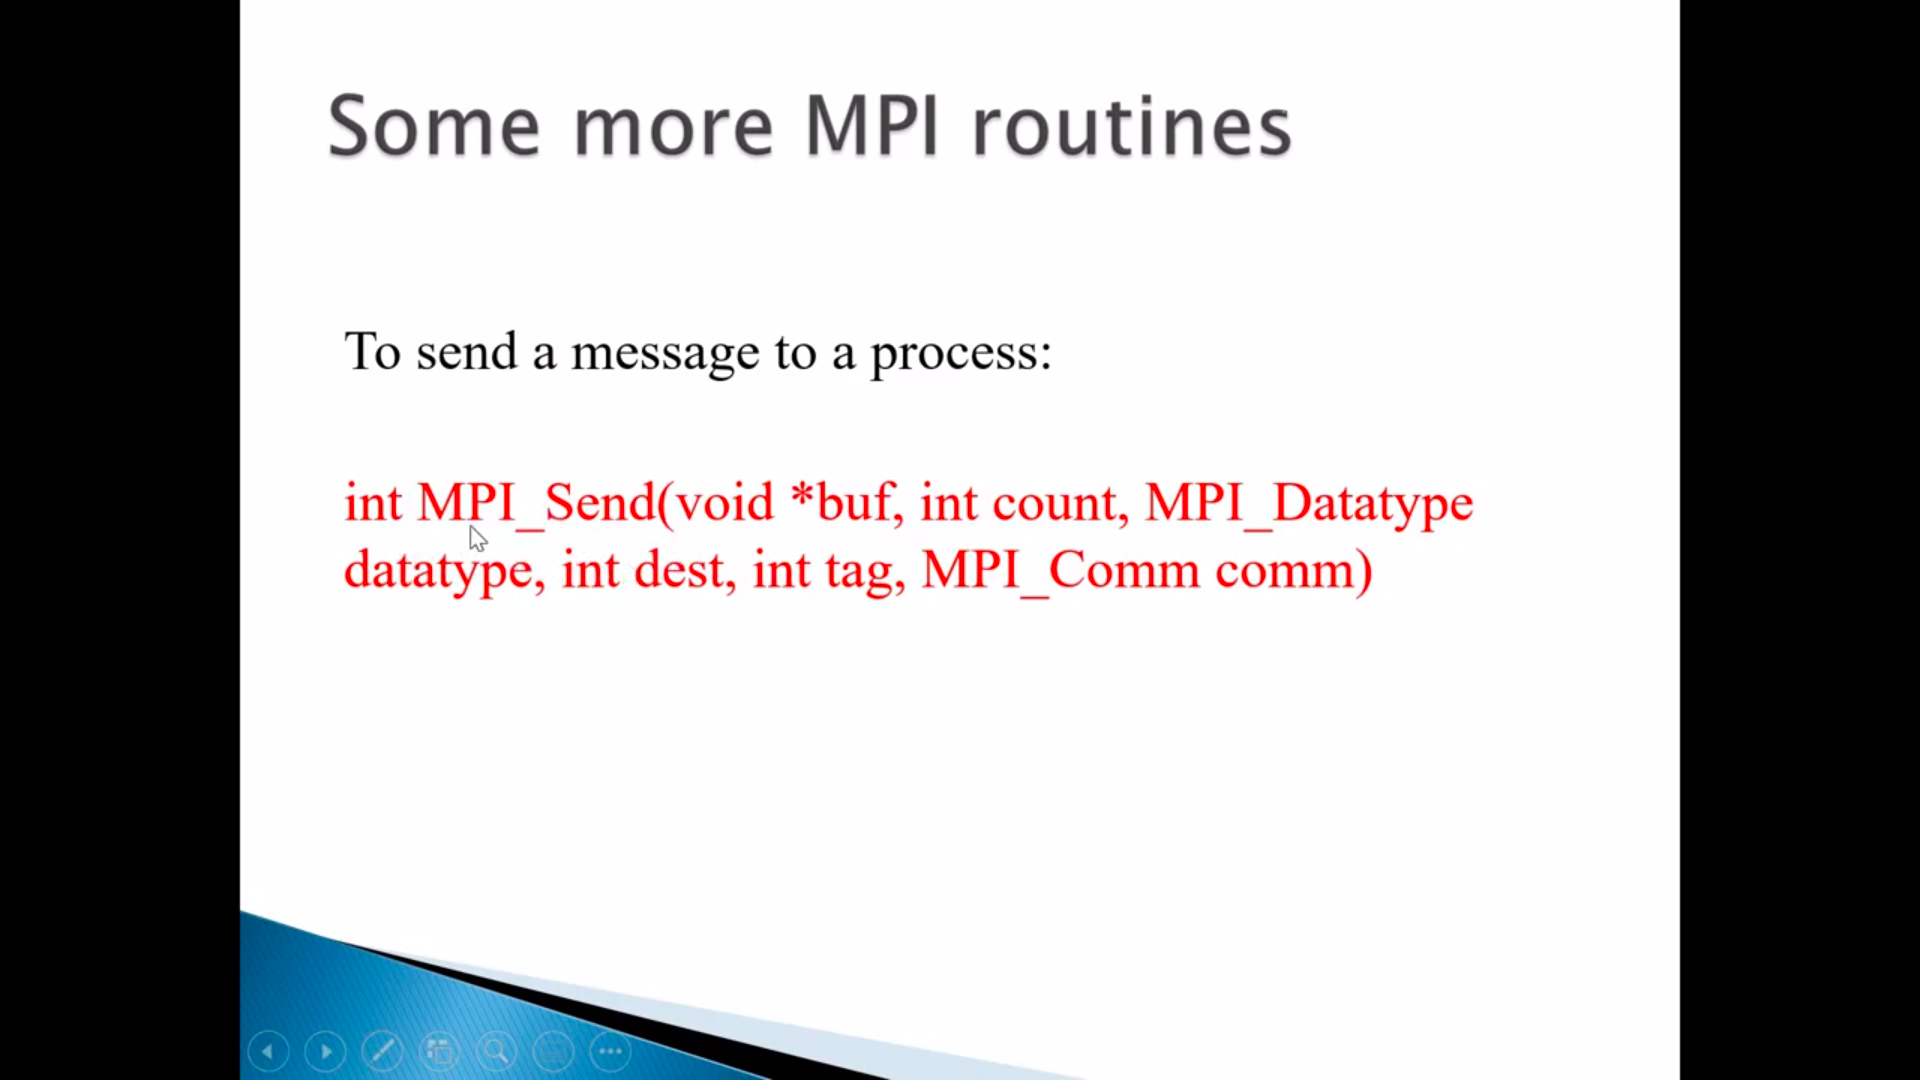

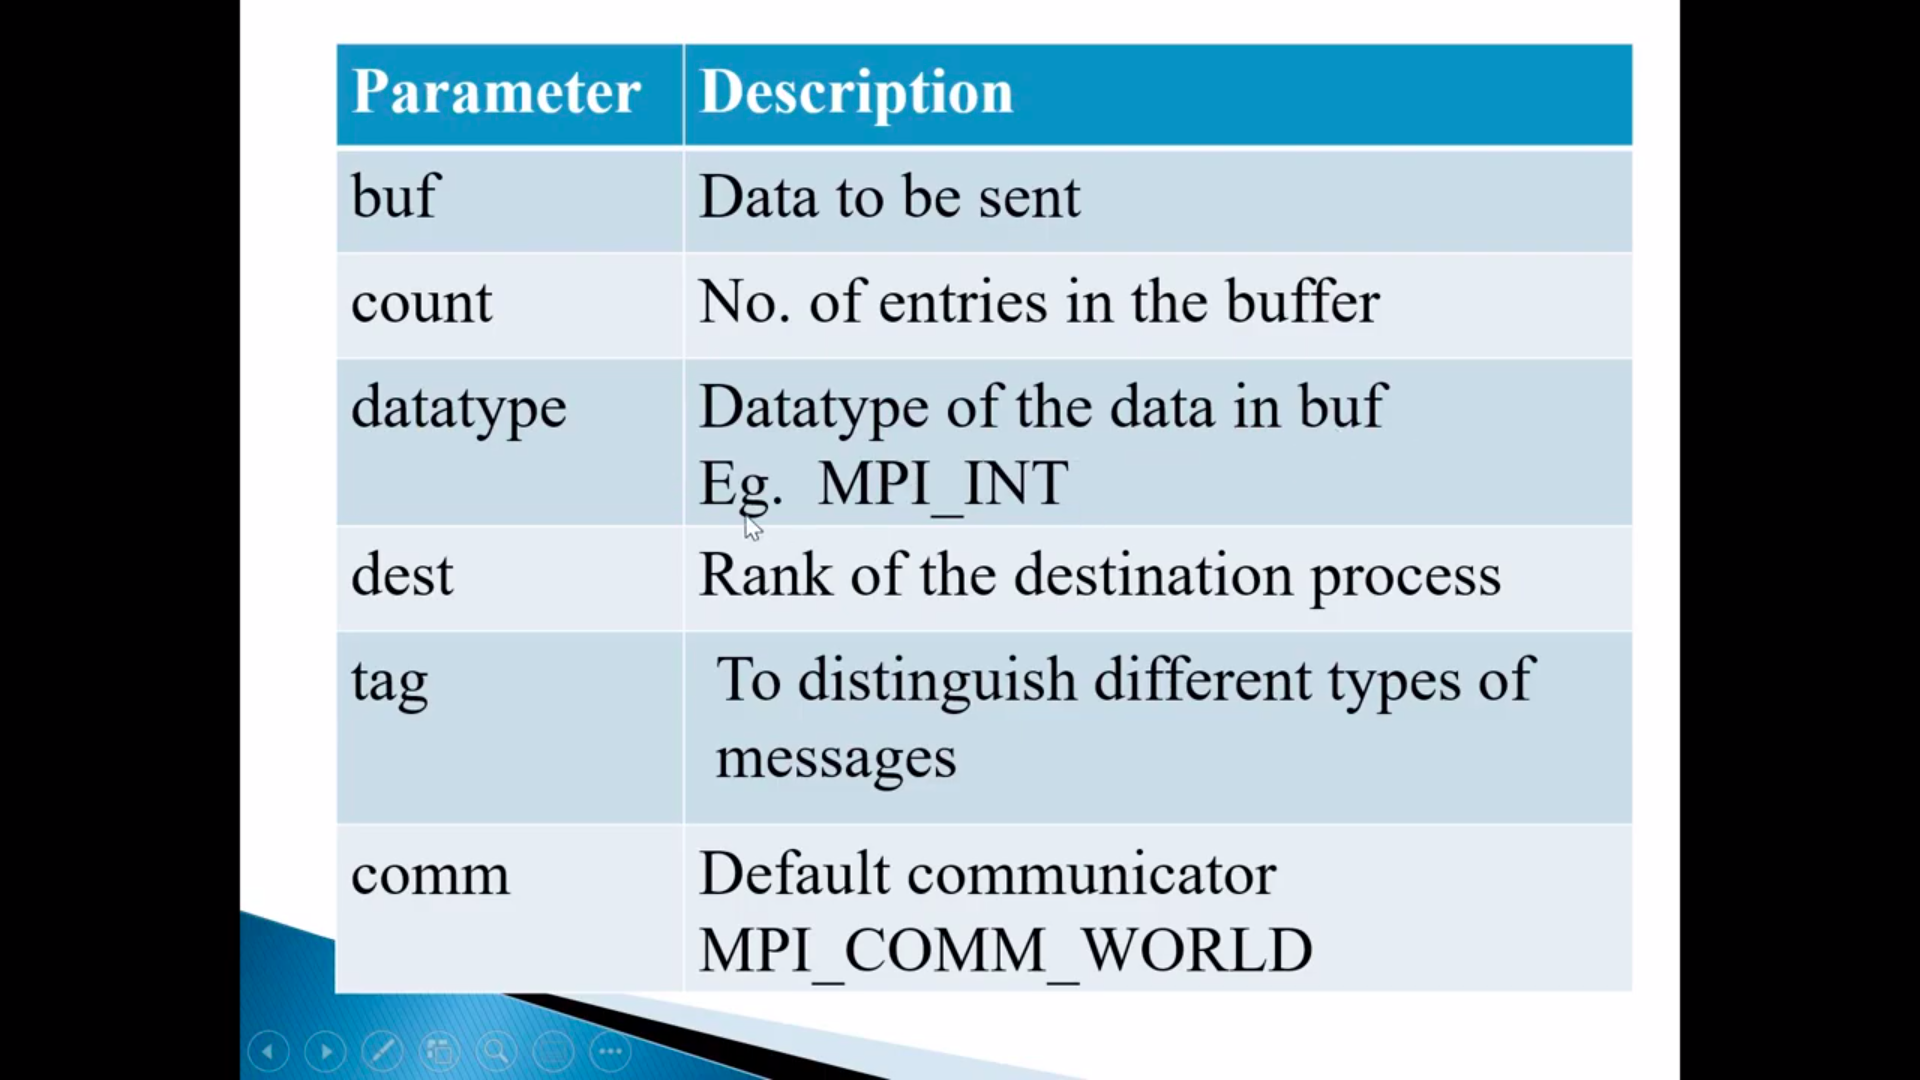

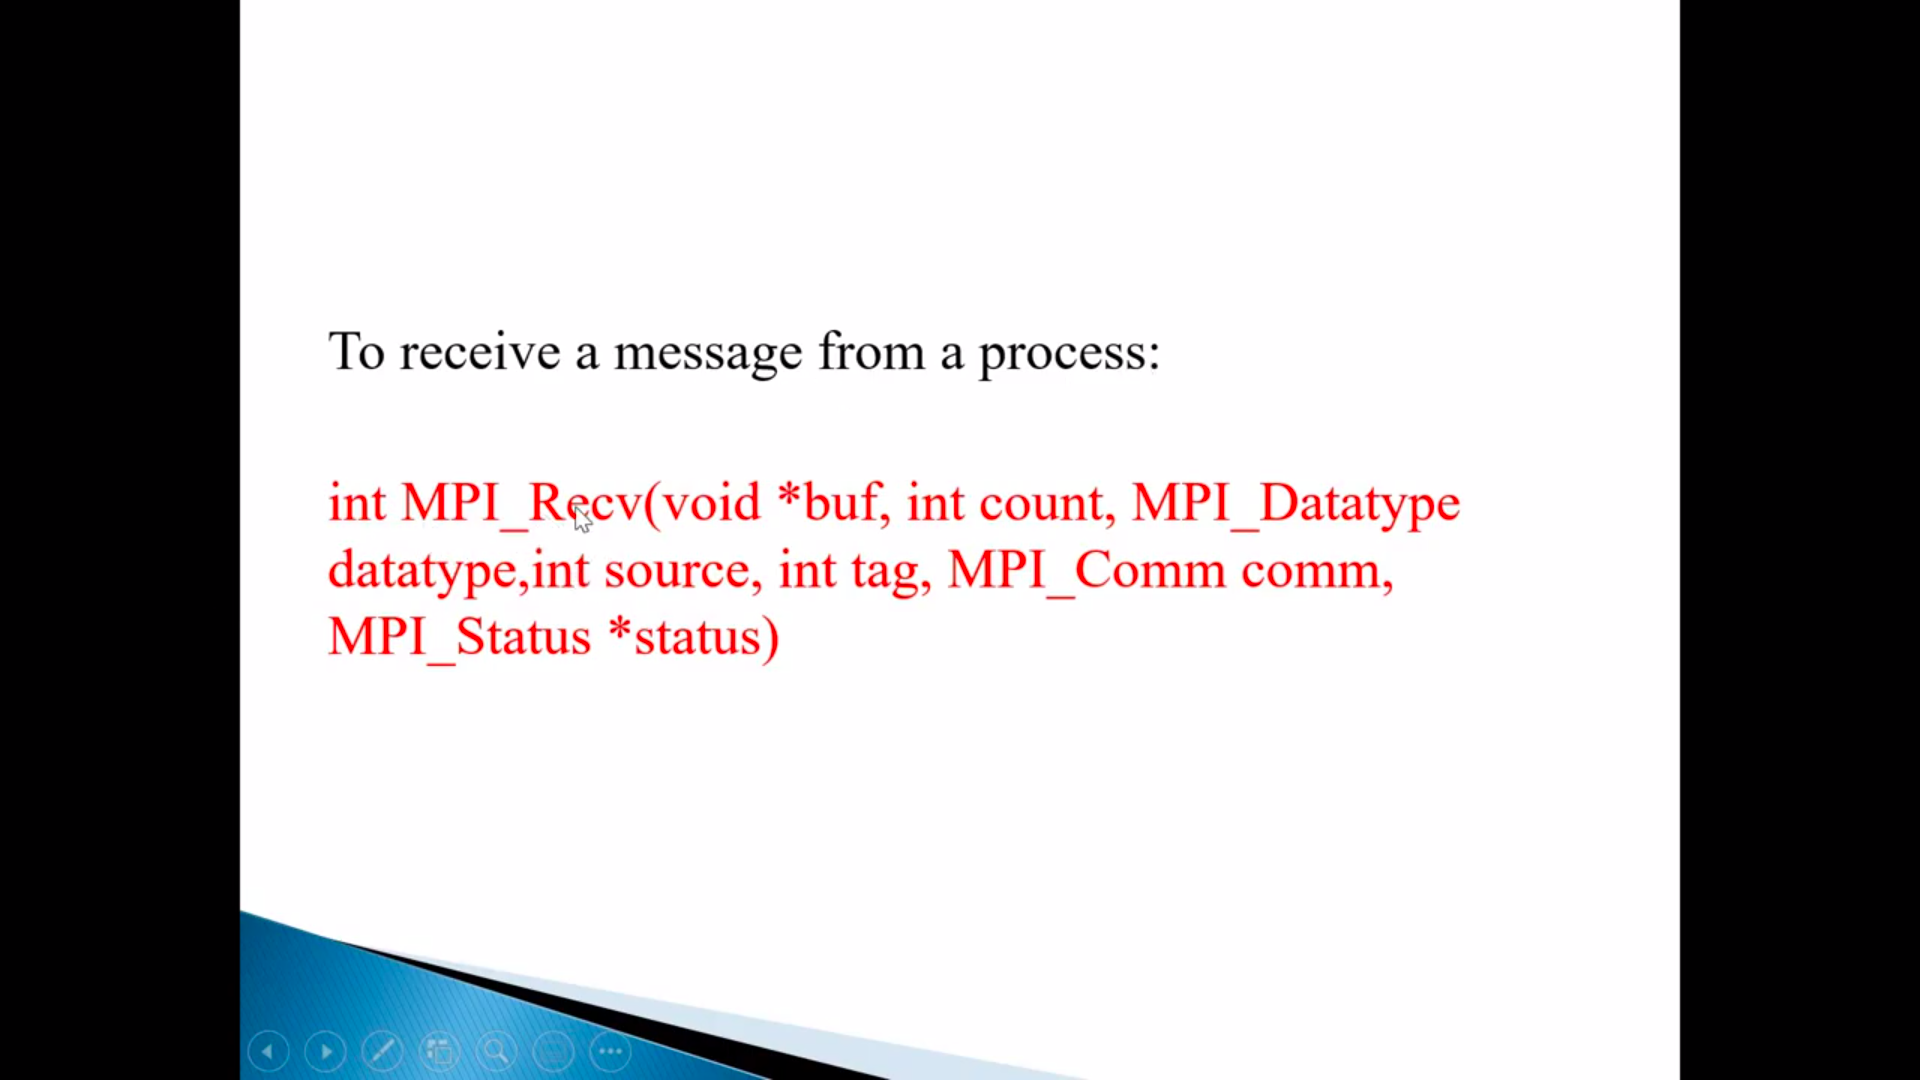

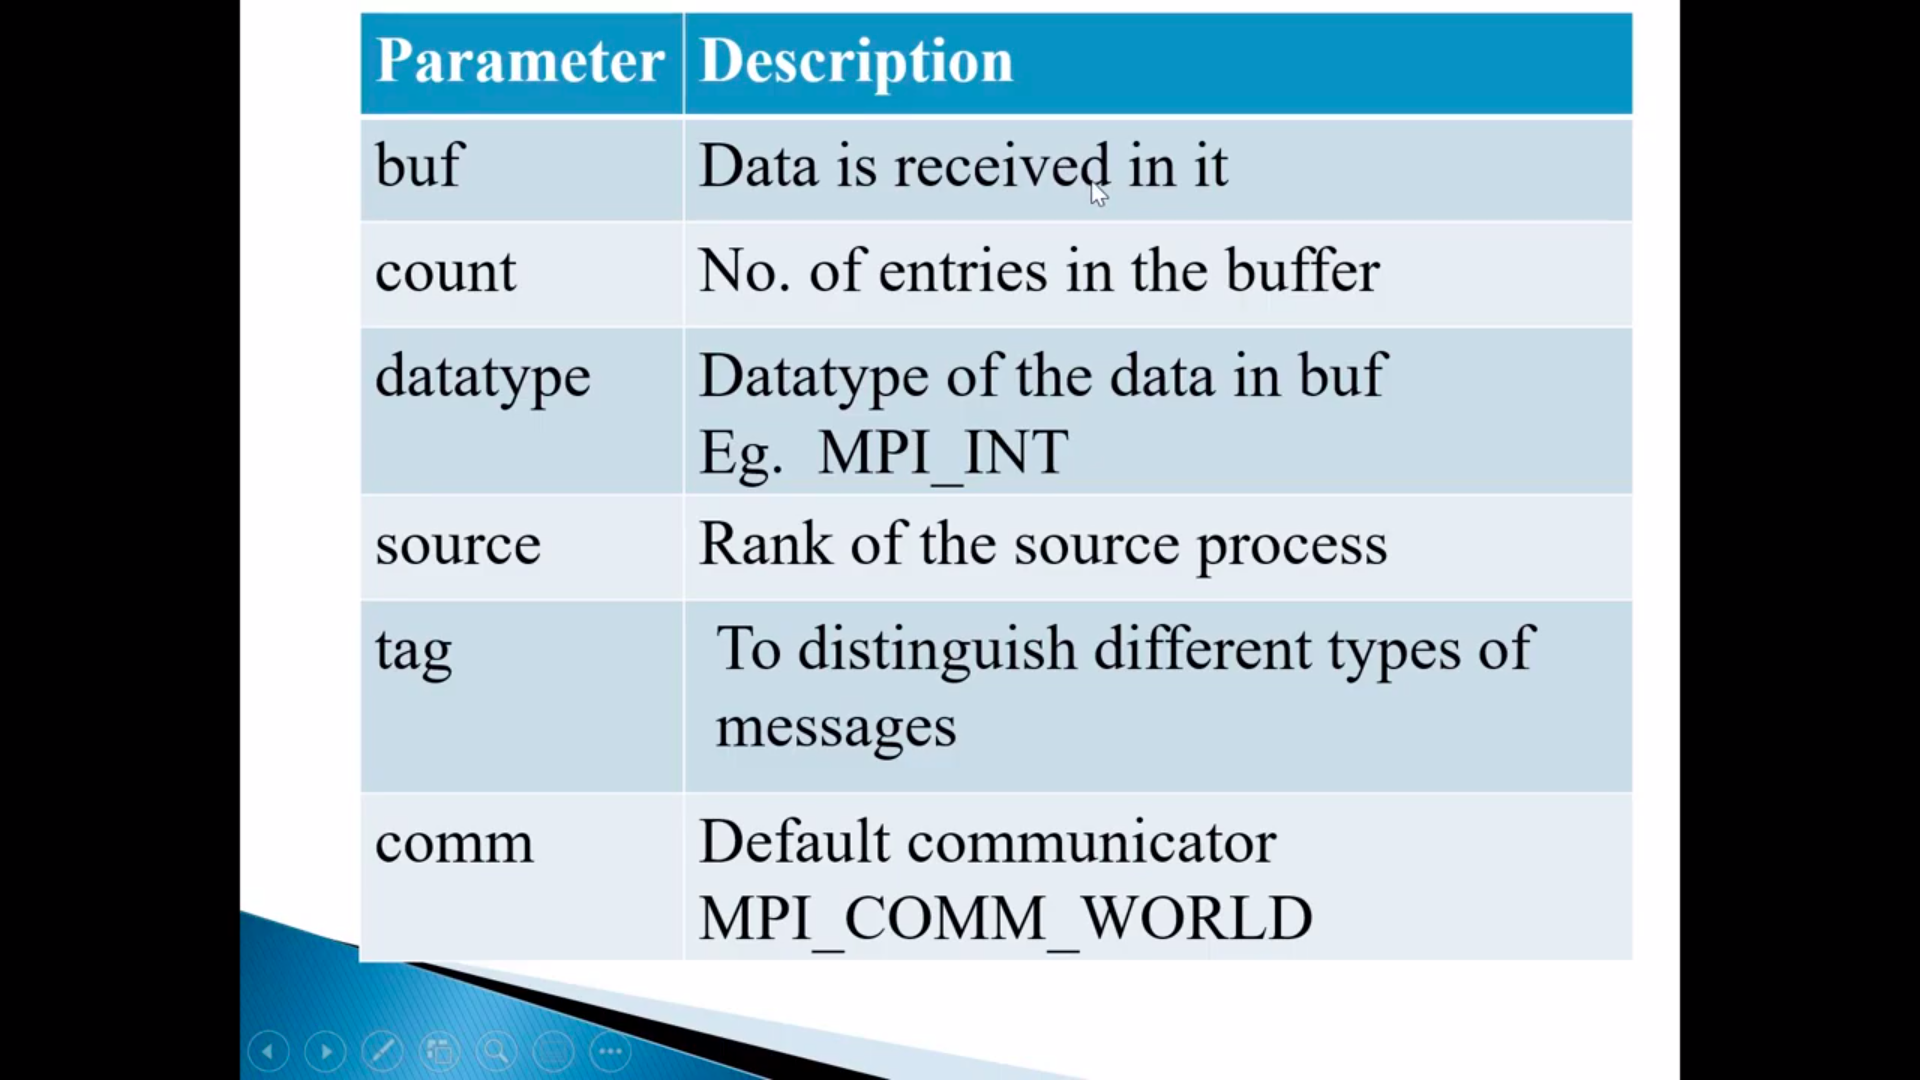

####Source Code

In [ ]:
%%writefile binary.cpp
#include<mpi.h>
#include<iostream>
using namespace std;

int n = 12;
int a[] = {1,2,3,4,7,9,13,24,55,56,67,88};
int key = 55;

//Temporary Array for Slave Process
int buffer[20];

int binarySearch(int *array, int start, int end, int value) {
    int mid;
    while(start <= end) {
        mid = start + (end-start)/2;
        if(array[mid] == value) 
            return mid;
        else if(array[mid] > value)
            end = mid - 1;
        else
            start = mid + 1;
    }
    return -1;
}

int main(int argc, char* argv[]) {
    
    int pid, np, elements_per_process, n_elements_received;
    
    MPI_Status status;
    
    //Initialize MPI Environment
    MPI_Init(&argc, &argv);
    
    //To get rank of a process
    MPI_Comm_rank(MPI_COMM_WORLD, &pid);
    
    //To get number of processes which are communicating
    //MPI_COMM_WORLD is the default communicator
    MPI_Comm_size(MPI_COMM_WORLD, &np);
    
    //Master Process
    if(pid == 0) {
        int index, i;

        //Check if more than one process is running
        if(np > 1) {
            for(i=1; i<np-1; i++) {
                
                index = i * elements_per_process;

                //Send the number of elements to the slave process
                MPI_Send(&elements_per_process, 1, MPI_INT, i, 0, MPI_COMM_WORLD);

                //Send the actual element to the slave process
                MPI_Send(&a[index], elements_per_process, MPI_INT, i, 0, MPI_COMM_WORLD);
            
            }
            
            //For the last process
            
            index = i* elements_per_process;
            int elements_left = n - index;

            //Send the number of elements to the slave process
            MPI_Send(&elements_left, 1, MPI_INT, i, 0, MPI_COMM_WORLD);

            //Send the actual element to the slave process
            MPI_Send(&a[index], elements_left, MPI_INT, i, 0, MPI_COMM_WORLD);
        }
        
        //Master itself performs binary search
        int position = binarySearch(a, 0, elements_per_process-1, key);
        printf("Position by Process ID %d = %d \n",pid,position);
        if(position != -1)
            cout<<"Found at: "<<position<<" by 0";
        
        //Collect Partial Result (Search Index) from Slave Processes
        int temp;
        for(i=1; i<np; i++) {
            
            //Get Search Index from each Slave Process
            MPI_Recv(&temp, 1, MPI_INT, MPI_ANY_SOURCE, 0, MPI_COMM_WORLD, &status);

            //Process ID of the slave process
            int sender = status.MPI_SOURCE;
            
            //Display search index if found
            if(temp != -1)
                cout<<"Found at: "<<((sender*elements_per_process)+temp)<<" by "<<sender;
        }
    }
    
    //Slave Process
    else {
        
        //Recieve number of elements from master process
        MPI_Recv(&n_elements_received, 1, MPI_INT, 0, 0, MPI_COMM_WORLD, &status);
        
        //Recieve the elements from master process
        MPI_Recv(&buffer, n_elements_received, MPI_INT, 0, 0, MPI_COMM_WORLD, &status);
    
        //Calculate the partial index
        int position = binarySearch(buffer, 0, n_elements_received-1, key);
        printf("Position by Process ID %d = %d \n",pid,position);
        
        //Send the partial index back to the master process
        MPI_Send(&position, 1, MPI_INT, 0, 0, MPI_COMM_WORLD);
    }
    
    //Terminate MPI Environment
    MPI_Finalize();
    
    return 0;
}

Overwriting binary.cpp


In [ ]:
!mpiCC binary.cpp
!mpirun --allow-run-as-root -np 4 ./a.out

Position by Process ID 0 = -1 
Position by Process ID 2 = -1 
Position by Process ID 3 = 8 
Position by Process ID 1 = -1 
Found at: 8 by 3

###Best First Search

####Example Graph

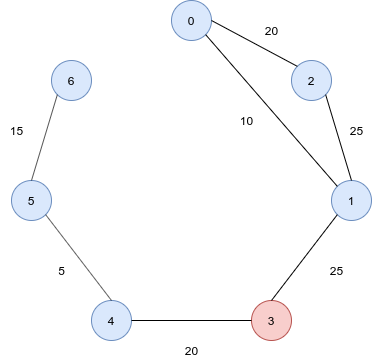

####Source Code

In [ ]:
%%writefile bfs.cpp
#include<bits/stdc++.h>
#include "omp.h"

#define n_nodes 7

using namespace std;
list<int>q;
vector<int>weight(n_nodes,1000);
bool visited[n_nodes];

struct Comparator {
    // Compare 2 Edges objects using weight
    bool operator ()(const int &e1, const int &e2){
        return weight[e1]<weight[e2];
    }
};

//Display the list/priority queue - Debugging Function
void showlist(list <int> g) { 
    list <int> :: iterator it; 
    for(it = g.begin(); it != g.end(); ++it) 
        cout<<*it<<" "; 
    cout<<endl; 
}

//Display the vector/weights - Debugging Function
void showvec(vector <int> g) { 
    vector <int> :: iterator it; 
    for(it = g.begin(); it != g.end(); ++it) 
        cout<<*it<<" "; 
    cout<<endl; 
}

void bfs(int adj_matrix[n_nodes][n_nodes])
{
		if(q.empty())
			return;
    q.sort(Comparator());
		
		//pop first element and display it
		int cur_node = q.front();
    q.pop_front();
		printf("%d, ", cur_node);
	
		//For every element in the row of the adjacency matrix
		#pragma omp parallel for shared(visited,q,weight)
		for(int i=0; i<n_nodes; i++)
		{
			//If an unvisited Edge exists
			if(adj_matrix[cur_node][i]>0 && visited[i]==false)
			{

				//Replace the weight if it is larger
        if(weight[i] > adj_matrix[cur_node][i]){
            weight[i] = adj_matrix[cur_node][i];
        }

				//Push the destination of the smallest edge onto the queue
				q.push_back(i);
				visited[i]=true;
			}
		}
	
	//Call the function recursively
	bfs(adj_matrix);
}

int main(){
	
	//Get the maximum number of threads
  int th = omp_get_max_threads();
  cout<<"Number of Threads = "<<th<<endl;

	//Set the Adjacency Matrix
	int adj_matrix[n_nodes][n_nodes] = {
							{0	,10  ,15  ,0  ,0  ,0  ,0},
							{10	,0	,25	,25	,0	,0	,0},
							{15	,25	,0	,0	,40	,0	,0},
							{0	,25	,0	,0	,20	,0	,0},
							{0	,0	,40	,20	,0	,5	,0},
							{0	,0	,0	,0	,5	,0	,20},
							{0	,0	,0	,0	,0	,20	,0}
							};
	
	//Initialize visited boolean array
	for(int i=0; i<n_nodes; i++){
		visited[i] = false;
	}

	//Set the start node
	int start_node = 3;

	//Set up the queue, weight and visited
	q.push_back(start_node);
    weight[start_node] = 0;
	visited[start_node] = true;
	
	//Best first Search
	bfs(adj_matrix);

	return 0;
}

Overwriting bfs.cpp


In [ ]:
!g++ -fopenmp bfs.cpp
!./a.out

Number of Threads = 2
3, 4, 5, 6, 1, 0, 2, 

##Modification

###Graph with a clique

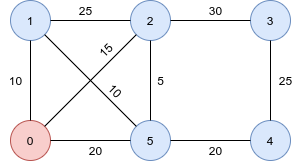

####Source Code

In [ ]:
%%writefile bfs.cpp
#include<bits/stdc++.h>
#include "omp.h"

#define n_nodes 6

using namespace std;
list<int>q;
vector<int>weight(n_nodes,1000);
bool visited[n_nodes];

struct Comparator {
    // Compare 2 Edges objects using weight
    bool operator ()(const int &e1, const int &e2){
        return weight[e1]<weight[e2];
    }
};

//Display the list/priority queue - Debugging Function
void showlist(list <int> g) { 
    list <int> :: iterator it; 
    for(it = g.begin(); it != g.end(); ++it) 
        cout<<*it<<" "; 
    cout<<endl; 
}

//Display the vector/weights - Debugging Function
void showvec(vector <int> g) { 
    vector <int> :: iterator it; 
    for(it = g.begin(); it != g.end(); ++it) 
        cout<<*it<<" "; 
    cout<<endl; 
}

void bfs(int adj_matrix[n_nodes][n_nodes])
{
		if(q.empty())
			return;
    q.sort(Comparator());
		
		//pop first element and display it
		int cur_node = q.front();
    q.pop_front();
		printf("%d, ", cur_node);
	
		//For every element in the row of the adjacency matrix
		#pragma omp parallel for shared(visited,q,weight)
		for(int i=0; i<n_nodes; i++)
		{
			//If an unvisited Edge exists
			if(adj_matrix[cur_node][i]>0 && visited[i]==false)
			{

				//Replace the weight if it is larger
        if(weight[i] > adj_matrix[cur_node][i]){
            weight[i] = adj_matrix[cur_node][i];
        }

				//Push the destination of the smallest edge onto the queue
				q.push_back(i);
				visited[i]=true;
			}
		}
	
	//Call the function recursively
	bfs(adj_matrix);
}

int main(){
	
	//Get the maximum number of threads
  int th = omp_get_max_threads();
  cout<<"Number of Threads = "<<th<<endl;

	//Set the Adjacency Matrix
	int adj_matrix[n_nodes][n_nodes] = {
							{0	,10	,15	,0	,0	,20	},
							{10	,0	,25	,0	,0	,10	},
							{15	,25	,0	,30	,0	,5	},
							{0	,0	,30	,0	,25	,0	},
							{0	,0	,0	,25	,0	,20	},
							{20	,10	,5	,0	,20	,0	}
							};
	
	//Initialize visited boolean array
	for(int i=0; i<n_nodes; i++){
		visited[i] = false;
	}

	//Set the start node
	int start_node = 0;

	//Set up the queue, weight and visited
	q.push_back(start_node);
    weight[start_node] = 0;
	visited[start_node] = true;
	
	//Best first Search
	bfs(adj_matrix);

	return 0;
}

Overwriting bfs.cpp


In [ ]:
!g++ -fopenmp bfs.cpp
!./a.out

Number of Threads = 2
0, 1, 2, 5, 4, 3, 